In [47]:

import pandas as pd
import re
from collections import defaultdict, Counter
import spacy
import glob
import string
from spacy.matcher import Matcher 
from spacy.training import Example
import os
import sys
import numpy as np
from pathlib import Path
import nltk
from rake_nltk import Rake
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')
from sklearn_crfsuite import CRF,metrics
import spacy
from collections import defaultdict, Counter
import networkx as nx
from spacy.matcher import PhraseMatcher
from collections import defaultdict
from tqdm.auto import tqdm
import string
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from nltk.corpus import stopwords
from nltk.stem  import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from spacy.training import Example
from spacy.scorer import Scorer
from datos_entrenamiento import TRAIN_DATA, TEST_DATA
import random
from spacy.pipeline import EntityRuler

In [2]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\amber\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\amber\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\amber\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
folder_path = "C:/Users/amber/Downloads/archive/"
libros = {}
for filename in sorted(os.listdir(folder_path)):
    if filename.endswith(".txt"):
        with open(os.path.join(folder_path, filename), "r", encoding="utf-8") as f:
            libros[filename] = f.read()
for nombre, texto in libros.items():
    print(f"{nombre}: {len(texto)} caracteres")


01 Harry Potter and the Sorcerers Stone.txt: 439516 caracteres
02 Harry Potter and the Chamber of Secrets.txt: 492336 caracteres
03 Harry Potter and the Prisoner of Azkaban.txt: 625764 caracteres
04 Harry Potter and the Goblet of Fire.txt: 1100552 caracteres
05 Harry Potter and the Order of the Phoenix.txt: 1499693 caracteres
06 Harry Potter and the Half-Blood Prince.txt: 988173 caracteres
07 Harry Potter and the Deathly Hallows.txt: 1140043 caracteres


<div style="background:#FFFFE0;padding:20px;color:#000000;margin-top:10px;">
<b>📝 Consideraciones Iniciales</b><br/><br/>
En esta primera parte, mi intención principal fue, ante todo, comenzar descargando los datos que iba a utilizar, es decir, los archivos. Posteriormente, me enfoqué en observar su estructura general y primitiva. Cabe destacar que, desde el inicio, comencé instalando las librerías que consideré oportunas, así como cualquier herramienta que resultara necesaria.
</div>

In [5]:
for nombre_libro, texto_completo in list(libros.items())[6:7]:  # probar libro num
    print(f"\n=== DIAGNÓSTICO: {nombre_libro} ===")
    
    patron_mejorado = r'CHAPTER\s+[A-Z-]+(?:\w*)?'
    
    chapter_matches = []
    for match in re.finditer(patron_mejorado, texto_completo):
        start = match.start()
        end = start + 200  # Los siguientes 200 caracteres
        sample = texto_completo[start:end].replace('\n', '\\n')
        chapter_matches.append((match.group(), sample))
    
    print(f"Capítulos encontrados: {len(chapter_matches)}")
    for i, (chapter, sample) in enumerate(chapter_matches):
        print(f"{i+1}. {chapter}")
        #print(f"   Contexto: {sample}...")
    print()



=== DIAGNÓSTICO: 07 Harry Potter and the Deathly Hallows.txt ===
Capítulos encontrados: 36
1. CHAPTER ONE
2. CHAPTER TWO
3. CHAPTER THREE
4. CHAPTER FOUR
5. CHAPTER FIVE
6. CHAPTER SIX
7. CHAPTER SEVEN
8. CHAPTER EIGHT
9. CHAPTER NINE
10. CHAPTER TEN
11. CHAPTER ELEVEN
12. CHAPTER TWELVE
13. CHAPTER THIRTEEN
14. CHAPTER FOURTEEN
15. CHAPTER FIFTEEN
16. CHAPTER SIXTEEN
17. CHAPTER SEVENTEEN
18. CHAPTER EIGHTTEEN
19. CHAPTER NINETEEN
20. CHAPTER TWENTY
21. CHAPTER TWENTY-ONE
22. CHAPTER TWENTY-TWO
23. CHAPTER TWENTY-THREE
24. CHAPTER TWENTY-FOUR
25. CHAPTER TWENTY-FIVE
26. CHAPTER TWENTY-SIX
27. CHAPTER TWENTY-SEVEN
28. CHAPTER TWENTY-EIGHT
29. CHAPTER TWENTY-NINE
30. CHAPTER THIRTY
31. CHAPTER THIRDTY-ONE
32. CHAPTER THIRTY-TWO
33. CHAPTER THIRTY-THREE
34. CHAPTER THIRTY-FOUR
35. CHAPTER THIRTY-FIVE
36. CHAPTER THIRTY-SIX



In [6]:

# Preprocesamiento: eliminar líneas en blanco excesivas de los libros
libros_limpios = {}
for nombre, texto in libros.items():
    # Eliminar líneas completamente vacías y normalizar espacios
    lineas = texto.split('\n')
    lineas_limpias = []
    for linea in lineas:
        linea_limpia = linea.strip()
        if linea_limpia:  # Solo agregar líneas que no estén vacías
            lineas_limpias.append(linea_limpia)
    
    libros_limpios[nombre] = '\n'.join(lineas_limpias)
    print(f"{nombre}: {len(texto)} -> {len(libros_limpios[nombre])} caracteres (limpio)")

01 Harry Potter and the Sorcerers Stone.txt: 439516 -> 436029 caracteres (limpio)
02 Harry Potter and the Chamber of Secrets.txt: 492336 -> 488802 caracteres (limpio)
03 Harry Potter and the Prisoner of Azkaban.txt: 625764 -> 621157 caracteres (limpio)
04 Harry Potter and the Goblet of Fire.txt: 1100552 -> 1093698 caracteres (limpio)
05 Harry Potter and the Order of the Phoenix.txt: 1499693 -> 1489930 caracteres (limpio)
06 Harry Potter and the Half-Blood Prince.txt: 988173 -> 982205 caracteres (limpio)
07 Harry Potter and the Deathly Hallows.txt: 1140043 -> 1133088 caracteres (limpio)


<div style="background:#FFFFE0;padding:20px;color:#000000;margin-top:10px;">
<b>📝 Limpieza y estructuración </b><br/><br/>
En esta parte, la idea era estructurar los datos en un DataFrame que me permitiera interpretarlos y visualizarlos de manera más clara. Al mismo tiempo, apliqué una limpieza básica pero necesaria, adecuada para tareas de extracción de entidades (NER). Esta limpieza buscaba evitar interferencias o ruidos durante la ejecución del código o cualquier otro procesamiento posterior.
</div>

In [7]:
# Procesamiento principal con regex mejorado
datos_estructurados = []
for nombre_libro, texto_completo in libros_limpios.items():
    print(f"Procesando: {nombre_libro}")
    
    
    patron_capitulos = r'CHAPTER\s+(?:[A-Z-]+(?:\w*)?|\d+)'
    
    # Buscar todas las posiciones donde aparece "CHAPTER" (case-insensitive)
    chapter_positions = []
    for match in re.finditer(patron_capitulos, texto_completo):
        chapter_positions.append(match.start())
    
    print(f"  - Capítulos encontrados: {len(chapter_positions)}")
    
    numero_capitulo = 1
    for i, pos in enumerate(chapter_positions):
        # Determinar el final de este capítulo (inicio del siguiente o final del texto)
        if i + 1 < len(chapter_positions):
            fin_capitulo = chapter_positions[i + 1]
        else:
            fin_capitulo = len(texto_completo)
        
        # Extraer el texto del capítulo completo
        texto_capitulo_completo = texto_completo[pos:fin_capitulo].strip()
        lineas_capitulo = texto_capitulo_completo.split('\n')
        
        if len(lineas_capitulo) >= 2:
            chapter_line = lineas_capitulo[0].strip()  # "CHAPTER THIRTY-SEVEN"
            titulo_capitulo = lineas_capitulo[1].strip()  # "THE BEGINNING"
            
            # El texto del capítulo es todo lo que sigue después del título
            texto_contenido = '\n'.join(lineas_capitulo[2:]).strip()
            
            # Solo procesar si el texto tiene contenido significativo
            if len(texto_contenido) > 100:
                # Limpiar texto básico
                texto_limpio = re.sub(r'\n+', ' ', texto_contenido)
                texto_limpio = re.sub(r'\s+', ' ', texto_limpio).strip()
                
                datos_estructurados.append({
                    'libro': nombre_libro.replace('.txt', ''),
                    'capitulo_num': numero_capitulo,
                    'chapter_line': chapter_line,  # "CHAPTER THIRTY-SEVEN"
                    'titulo_capitulo': titulo_capitulo,  # "THE BEGINNING"
                    'texto': texto_limpio,
                    'longitud': len(texto_limpio)
                })
                numero_capitulo += 1
                print(f"    Cap {numero_capitulo-1}: {chapter_line} - {titulo_capitulo[:50]}...")

Procesando: 01 Harry Potter and the Sorcerers Stone.txt
  - Capítulos encontrados: 17
    Cap 1: CHAPTER ONE - THE BOY WHO LIVED...
    Cap 2: CHAPTER TWO - THE VANISHING GLASS...
    Cap 3: CHAPTER THREE - LETTERS FROM NO ONE...
    Cap 4: CHAPTER FOUR - THE KEEPER OF THE KEYS...
    Cap 5: CHAPTER FIVE - DIAGON ALLEY...
    Cap 6: CHAPTER SIX - THE JOURNEY FROM PLATFORM NINE AND THREE-QUARTERS...
    Cap 7: CHAPTER SEVEN - THE SORTING HAT...
    Cap 8: CHAPTER EIGHT - THE POTIONS MASTER...
    Cap 9: CHAPTER NINE - THE MIDNIGHT DUEL...
    Cap 10: CHAPTER TEN - HALLOWEEN...
    Cap 11: CHAPTER ELEVEN - QUIDDITCH...
    Cap 12: CHAPTER TWELVE - THE MIRROR OF ERISED...
    Cap 13: CHAPTER THIRTEEN - NICHOLAS FLAMEL...
    Cap 14: CHAPTER FOURTEEN - NORBERT THE NORWEGIAN RIDGEBACK...
    Cap 15: CHAPTER FIFTEEN - THE FORBIDDEN FOREST...
    Cap 16: CHAPTER SIXTEEN - THROUGH THE TRAPDOOR...
    Cap 17: CHAPTER SEVENTEEN - THE MAN WITH TWO FACES...
Procesando: 02 Harry Potter and the Cham

<div style="background:#FFFFE0;padding:20px;color:#000000;margin-top:10px;">
<b>📝 Visualizar hallazgos </b><br/><br/>
El propósito de esta parte es fundamental, ya que me permite visualizar de forma gráfica algunos de los hallazgos más relevantes relacionados con las actividades que desarrollaré posteriormente. Cabe destacar que esta fue, en comparación, una de las etapas más superficiales del proceso que puedo mostrar, ya que mi trabajo implicó numerosas acciones manuales, tanto de clasificación como de modificación directa de los datos originales. Estas tareas fueron necesarias para lograr interpretar, comprender y adaptar la información a los formatos con los que estuve trabajando. Todo esto requirió un análisis detallado de los resúmenes de los libros y de los elementos relacionados, con el fin de entender con mayor claridad el tipo de datos que estaba manipulando. Lo cual no puede reflejarse aquí.
</div>

In [8]:

print(f"\nDataset creado: {len(datos_estructurados)} capítulos en total")
df_libros = pd.DataFrame(datos_estructurados)
print(f"Libros procesados: {df_libros['libro'].nunique()}")
print(f"Distribución por libro:")
print(df_libros.groupby('libro').size())
df_libros.head()


Dataset creado: 197 capítulos en total
Libros procesados: 7
Distribución por libro:
libro
01 Harry Potter and the Sorcerers Stone         17
02 Harry Potter and the Chamber of Secrets      17
03 Harry Potter and the Prisoner of Azkaban     22
04 Harry Potter and the Goblet of Fire          37
05 Harry Potter and the Order of the Phoenix    38
06 Harry Potter and the Half-Blood Prince       30
07 Harry Potter and the Deathly Hallows         36
dtype: int64


,libro,capitulo_num,chapter_line,titulo_capitulo,texto,longitud
0,01 Harry Potter and the Sorcerers Stone,1,CHAPTER ONE,THE BOY WHO LIVED,"M r. and Mrs. Dursley, of number four, Privet ...",25725
1,01 Harry Potter and the Sorcerers Stone,2,CHAPTER TWO,THE VANISHING GLASS,N early ten years had passed since the Dursley...,19049
2,01 Harry Potter and the Sorcerers Stone,3,CHAPTER THREE,LETTERS FROM NO ONE,T he escape of the Brazilian boa constrictor e...,21432
3,01 Harry Potter and the Sorcerers Stone,4,CHAPTER FOUR,THE KEEPER OF THE KEYS,B OOM. They knocked again. Dudley jerked awake...,20229
4,01 Harry Potter and the Sorcerers Stone,5,CHAPTER FIVE,DIAGON ALLEY,H arry woke early the next morning. Although h...,37347


   ANALISIS ESTADISTICO DESCRIPTIVO - CORPUS HARRY POTTER

1. ESTADISTICAS GENERALES DEL CORPUS:
--------------------------------------------------
Total de libros procesados: 7
Total de capítulos extraídos: 197

Distribución de capítulos por libro:
  01 Harry Potter and the Sorcerers Stone: 17 capítulos
  02 Harry Potter and the Chamber of Secrets: 17 capítulos
  03 Harry Potter and the Prisoner of Azkaban: 22 capítulos
  04 Harry Potter and the Goblet of Fire: 37 capítulos
  05 Harry Potter and the Order of the Phoenix: 38 capítulos
  06 Harry Potter and the Half-Blood Prince: 30 capítulos
  07 Harry Potter and the Deathly Hallows: 36 capítulos

2. ANALISIS DE LONGITUD DE TEXTOS:
--------------------------------------------------
Longitud promedio por capítulo: 31,664 caracteres
Longitud mediana: 31,483 caracteres
Desviación estándar: 8,842 caracteres
Capítulo más corto: 11,254 caracteres
Capítulo más largo: 50,576 caracteres
Total de caracteres en el corpus: 6,237,711

3. ANALISIS D

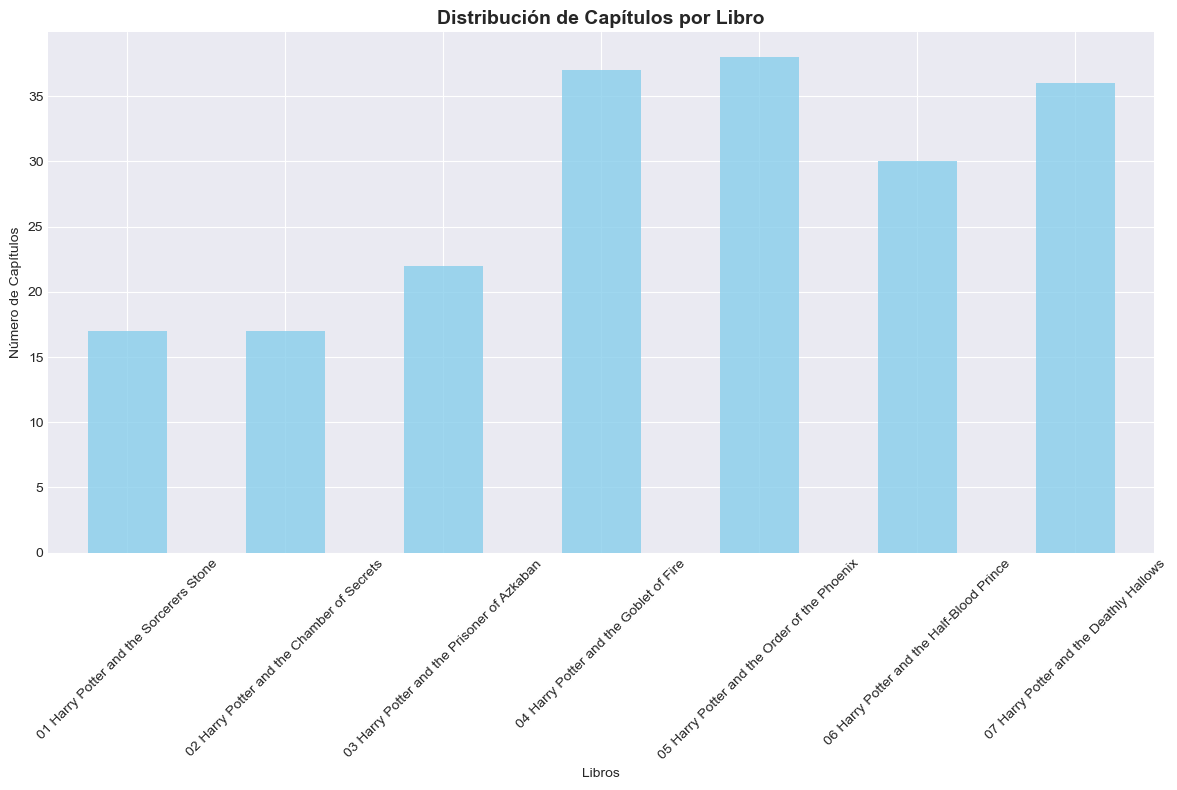


6. GENERANDO NUBE DE PALABRAS:
--------------------------------------------------


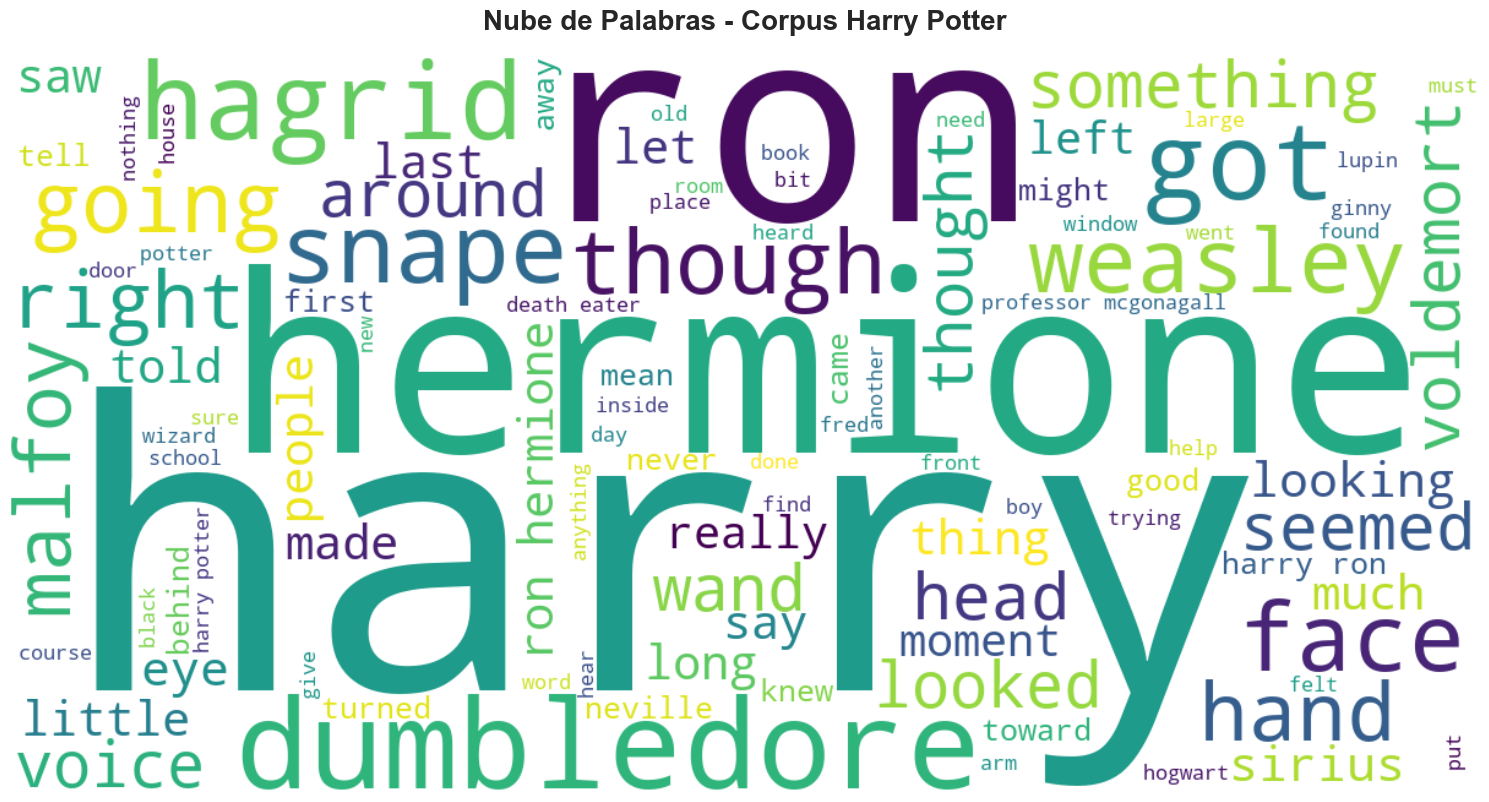

Nube de palabras generada exitosamente


In [ ]:

print("="*70)
print("   ANALISIS ESTADISTICO DESCRIPTIVO - CORPUS HARRY POTTER")
print("="*70)

print("\n1. ESTADISTICAS GENERALES DEL CORPUS:")
print("-" * 50)


total_capitulos = len(df_libros)
total_libros = df_libros['libro'].nunique()

print(f"Total de libros procesados: {total_libros}")
print(f"Total de capítulos extraídos: {total_capitulos}")

print(f"\nDistribución de capítulos por libro:")
distribucion_capitulos = df_libros['libro'].value_counts().sort_index()
for libro, num_caps in distribucion_capitulos.items():
    print(f"  {libro}: {num_caps} capítulos")


print(f"\n2. ANALISIS DE LONGITUD DE TEXTOS:")
print("-" * 50)


longitudes = df_libros['longitud']
print(f"Longitud promedio por capítulo: {longitudes.mean():,.0f} caracteres")
print(f"Longitud mediana: {longitudes.median():,.0f} caracteres")
print(f"Desviación estándar: {longitudes.std():,.0f} caracteres")
print(f"Capítulo más corto: {longitudes.min():,.0f} caracteres")
print(f"Capítulo más largo: {longitudes.max():,.0f} caracteres")

# Total de caracteres en el corpus
total_caracteres = longitudes.sum()
print(f"Total de caracteres en el corpus: {total_caracteres:,.0f}")

# 3. ANALISIS DE VOCABULARIO Y FRECUENCIAS
print(f"\n3. ANALISIS DE VOCABULARIO:")
print("-" * 50)

# Combinar todo el texto del corpus
texto_completo = ' '.join(df_libros['texto'].tolist())

# Tokenización básica
from nltk.tokenize import word_tokenize
import string

# Descargar recursos necesarios si no están disponibles
try:
    tokens = word_tokenize(texto_completo.lower())
except LookupError:
    nltk.download('punkt')
    tokens = word_tokenize(texto_completo.lower())

# Limpiar tokens (solo palabras, sin puntuación)
palabras = [token for token in tokens if token.isalpha() and len(token) > 2]

# Estadísticas de vocabulario
total_palabras = len(palabras)
vocabulario_unico = len(set(palabras))

print(f"Total de palabras en el corpus: {total_palabras:,}")
print(f"Vocabulario único (palabras distintas): {vocabulario_unico:,}")
print(f"Ratio de diversidad léxica: {vocabulario_unico/total_palabras:.3f}")

# 4. STOPWORDS Y PALABRAS MAS FRECUENTES
print(f"\n4. PALABRAS MAS FRECUENTES:")
print("-" * 50)

# Definir stopwords en inglés
try:
    from nltk.corpus import stopwords
    stop_words = set(stopwords.words('english'))
except LookupError:
    nltk.download('stopwords')
    from nltk.corpus import stopwords
    stop_words = set(stopwords.words('english'))

# Agregar algunas stopwords adicionales comunes en narrativa
stop_words.update(['said', 'would', 'could', 'one', 'two', 'three', 'way', 'time', 
                   'back', 'know', 'think', 'get', 'go', 'come', 'see', 'look',
                   'take', 'make', 'want', 'like', 'even', 'well', 'still'])

# Filtrar stopwords
palabras_filtradas = [palabra for palabra in palabras if palabra not in stop_words]

# Contar frecuencias
from collections import Counter
contador_palabras = Counter(palabras_filtradas)

# Top 20 palabras más frecuentes
top_20_palabras = contador_palabras.most_common(20)

print("TOP 20 PALABRAS MAS FRECUENTES (sin stopwords):")
print(f"{'Posición':<8} {'Palabra':<15} {'Frecuencia':<10} {'Porcentaje':<10}")
print("-" * 50)

total_palabras_filtradas = len(palabras_filtradas)
for i, (palabra, freq) in enumerate(top_20_palabras, 1):
    porcentaje = (freq / total_palabras_filtradas) * 100
    print(f"{i:<8} {palabra:<15} {freq:<10,} {porcentaje:<10.2f}%")

# 5. VISUALIZACION PRINCIPAL
print(f"\n5. GENERANDO VISUALIZACIÓN:")
print("-" * 50)

# Solo el gráfico de distribución de capítulos por libro
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

distribucion_capitulos.plot(kind='bar', ax=ax, color='skyblue', alpha=0.8)
ax.set_title('Distribución de Capítulos por Libro', fontsize=14, fontweight='bold')
ax.set_xlabel('Libros')
ax.set_ylabel('Número de Capítulos')
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# 6. NUBE DE PALABRAS
print(f"\n6. GENERANDO NUBE DE PALABRAS:")
print("-" * 50)

# Crear nube de palabras
try:
    from wordcloud import WordCloud
    
    # Preparar texto para la nube de palabras (solo palabras filtradas)
    texto_para_nube = ' '.join(palabras_filtradas)
    
    # Crear la nube de palabras
    wordcloud = WordCloud(
        width=1200, 
        height=600, 
        background_color='white',
        max_words=100,
        colormap='viridis',
        relative_scaling=0.5,
        random_state=42
    ).generate(texto_para_nube)
    
    # Mostrar la nube de palabras
    plt.figure(figsize=(15, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Nube de Palabras - Corpus Harry Potter', fontsize=20, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    
    print("Nube de palabras generada exitosamente")
    
except ImportError:
    print("WordCloud no está instalado. Instálalo con: pip install wordcloud")



In [10]:
%pip install spacy
!python -m spacy download en_core_web_md


Note: you may need to restart the kernel to use updated packages.
     ---------------------------------------- 0.0/33.5 MB ? eta -:--:--
      --------------------------------------- 0.8/33.5 MB 6.7 MB/s eta 0:00:05
     --- ------------------------------------ 2.6/33.5 MB 8.0 MB/s eta 0:00:04
     ---- ----------------------------------- 3.9/33.5 MB 7.3 MB/s eta 0:00:05
     ----- ---------------------------------- 5.0/33.5 MB 6.6 MB/s eta 0:00:05
     ------- -------------------------------- 6.0/33.5 MB 6.3 MB/s eta 0:00:05
     -------- ------------------------------- 6.8/33.5 MB 5.8 MB/s eta 0:00:05
     --------- ------------------------------ 7.6/33.5 MB 5.5 MB/s eta 0:00:05
     ---------- ----------------------------- 8.4/33.5 MB 5.4 MB/s eta 0:00:05
     ---------- ----------------------------- 9.2/33.5 MB 5.1 MB/s eta 0:00:05
     ------------ --------------------------- 10.2/33.5 MB 5.0 MB/s eta 0:00:05
     ------------- -------------------------- 11.0/33.5 MB 4.9 MB/s eta

In [11]:
nlp = spacy.load("en_core_web_md")

In [12]:
nlp.max_length = 2_000_000  

<div style="background:#FFFFE0;padding:20px;color:#000000;margin-top:10px;">
<b>📝 Primer modelo desallorado -El hibrido-</b><br/><br/>
Esta sección detalla el desarrollo del primer modelo implementado: un modelo híbrido. La lógica de este modelo consiste en un proceso de dos fases: primero, utiliza el análisis lingüístico y el reconocedor de entidades genérico de spaCy (versión en_core_web_md) para realizar una extracción inicial de posibles candidatos. En la segunda fase, se aplica un sistema de reglas personalizado, el cual se apoya en un diccionario exhaustivo que creamos con las entidades de PERSONAJE y OBJETO_MAGICO. Estas reglas, implementadas a través de funciones personalizadas, se encargan de validar, corregir y enriquecer las detecciones de spaCy, asegurando que el resultado final sea relevante para el universo de Harry Potter.
</div>

In [ ]:
# --- DICCIONARIOS DE ENTIDADES (CON CLAVES SIMPLES) ---
ENTIDADES_HP = {
    "PERSONAJES": {
        # Protagonistas principales
        'hedwig': 'Hedwig',
        'harry': 'Harry Potter',
        'harry potter': 'Harry Potter',
        'potter': 'Harry Potter',
        'hermione': 'Hermione Granger',
        'hermione granger': 'Hermione Granger',
        'granger': 'Hermione Granger',
        'ron': 'Ron Weasley',
        'ron weasley': 'Ron Weasley',
        'ronald': 'Ron Weasley',
        'ronald weasley': 'Ron Weasley',
        'weasley': 'Ron Weasley',
        'ginny': 'Ginny Weasley',
        'ginny weasley': 'Ginny Weasley',
        'ginerva': 'Ginny Weasley',
        'ginerva weasley': 'Ginny Weasley',
        'sirius': 'Sirius Black',
        'sirius black': 'Sirius Black',
        'cedric': 'Cedric Diggory',
        'cedric diggory': 'Cedric Diggory',

        # Profesores y personal de Hogwarts
        'dumbledore': 'Albus Dumbledore',
        'albus dumbledore': 'Albus Dumbledore',
        'albus': 'Albus Dumbledore',
        'professor dumbledore': 'Albus Dumbledore',
        'mcgonagall': 'Minerva McGonagall',
        'minerva mcgonagall': 'Minerva McGonagall',
        'minerva': 'Minerva McGonagall',
        'professor mcgonagall': 'Minerva McGonagall',
        'hagrid': 'Rubeus Hagrid',
        'rubeus hagrid': 'Rubeus Hagrid',
        'snape': 'Severus Snape',
        'severus snape': 'Severus Snape',
        'severus': 'Severus Snape',
        'professor snape': 'Severus Snape',
        'yaxley':'Yaxley',
        'dolohov':'Antonin Dolohov',

        # Familia Dursley
        'vernon': 'Vernon Dursley',
        'vernon dursley': 'Vernon Dursley',
        'uncle vernon': 'Vernon Dursley',
        'petunia': 'Petunia Dursley',
        'petunia dursley': 'Petunia Dursley',
        'aunt petunia': 'Petunia Dursley',
        'dudley': 'Dudley Dursley',
        'dudley dursley': 'Dudley Dursley',

        # Villanos
        'voldemort': 'Lord Voldemort',
        'lord voldemort': 'Lord Voldemort',
        'you-know-who': 'Lord Voldemort',
        'he-who-must-not-be-named': 'Lord Voldemort',

        # Padres de Harry
        'james': 'James Potter',
        'james potter': 'James Potter',
        'lily': 'Lily Potter',
        'lily potter': 'Lily Potter',
        'lily evans': 'Lily Potter',
        

        # Personajes principales adicionales por libro
        'quirrell': 'Quirinus Quirrell',
        'professor quirrell': 'Quirinus Quirrell',
        'neville': 'Neville Longbottom',
        'neville longbottom': 'Neville Longbottom',
        'draco': 'Draco Malfoy',
        'draco malfoy': 'Draco Malfoy',
        'malfoy': 'Draco Malfoy',
        'tom riddle': 'Tom Riddle',
        'riddle': 'Tom Riddle',
        'lucius': 'Lucius Malfoy',
        'lucius malfoy': 'Lucius Malfoy',
        'peter pettigrew': 'Peter Pettigrew',
        'pettigrew': 'Peter Pettigrew',
        'wormtail': 'Peter Pettigrew',
        'remus': 'Remus Lupin',
        'remus lupin': 'Remus Lupin',
        'lupin': 'Remus Lupin',
        'professor lupin': 'Remus Lupin',
        'barty crouch jr': 'Barty Crouch Jr.',
        'mad-eye moody': 'Alastor Moody',
        'alastor moody': 'Alastor Moody',
        'moody': 'Alastor Moody',
        'fleur': 'Fleur Delacour',
        'fleur delacour': 'Fleur Delacour',
        'krum': 'Viktor Krum',
        'viktor krum': 'Viktor Krum',
        'umbridge': 'Dolores Umbridge',
        'dolores umbridge': 'Dolores Umbridge',
        'professor umbridge': 'Dolores Umbridge',
        'bellatrix': 'Bellatrix Lestrange',
        'bellatrix lestrange': 'Bellatrix Lestrange',
        'kreacher': 'Kreacher',
        'slughorn': 'Horace Slughorn',
        'horace slughorn': 'Horace Slughorn',
        'professor slughorn': 'Horace Slughorn',
        'narcissa': 'Narcissa Malfoy',
        'narcissa malfoy': 'Narcissa Malfoy',
        'fenrir greyback': 'Fenrir Greyback',
        'greyback': 'Fenrir Greyback',
        'aberforth': 'Aberforth Dumbledore',
        'aberforth dumbledore': 'Aberforth Dumbledore',
        'grindelwald': 'Gellert Grindelwald',
        'gellert grindelwald': 'Gellert Grindelwald',
        'Norbert' :'Norbert',
        'rowle':'Thorfinn Rowle',
        'nagini':'Nagini',
        'oliver wood': 'Oliver Wood',
        'colin': 'Colin Creevey',
    },
    "OBJETO_MAGICO": {
        'wand', 'elder wand', 'philosophers stone', 'sorcerers stone',
        'time turner', 'pensieve', 'sorting hat', 'marauders map', 'horcrux',
        'resurrection stone', 'deathly hallows', 'nimbus 2000', 'firebolt',
        'remembrall', 'howler', 'floo powder', 'portkey', 'mirror of erised', 'put-outer',
        'fluffy', 'diary of tom riddle', 'sword of gryffindor', 'basilisk fang', 'polyjuice potion',
        'hand of glory', 'hippogriff', 'dementor', 'patronus', 'triwizard cup',
        'gillyweed', 'veritaserum', 'prophecy', 'the veil', 'felix felicis',
        'occlumency', 'legilimency', 'sectumsempra', 'vanishing cabinet', 'unbreakable vow',
        'deluminator',
        'invisibility cloak', 'snitch', "gaunt's ring","slytherin's locket", "hufflepuff's cup,",
        "ravenclaw's diadem",
    },

"PALABRAS_EXCLUIDAS": {
    'n’t', 'funny', 'nasty', 'harvey', 'harold', 'jim', 'ted',
    'mr', 'mrs', 'ms', 'dear', 'sir', 'madam', 'bonfire night', 'yeh',
    'don', 'ter', 'an', 'er', 'o', 'a', 'i',
    'jumped', 'people', 'said', 'looked', 'asked',
    'outta', 'kinda', 'gonna', 'wanna', 'gotta',
    'supreme', 'international', 'mugwump', 'the',
    'and', 'or', 'but'
}

}
PATRONES_INVALIDOS = [
    r'\b(harry|hermione|ron|dumbledore)\s+(said|asked|looked)\b',  # solo filtra si el verbo sigue directamente
    r'\b(yeh|ter|an|er)\b',  # filtra palabras sueltas sin contexto
]


In [ ]:
def es_entidad_valida(texto, palabras_excluidas, patrones_invalidos):
    if len(texto) < 2:
        return False
   
    palabras = texto.split()
    if any(palabra in palabras_excluidas for palabra in palabras):
        return False
    
    for patron in patrones_invalidos:
        if re.search(patron, texto):
            return False
    
    return True

def mapear_categoria_spacy(label_spacy):
    # Mapea etiquetas de spaCy solo a PERSONAJE y OBJETO_MAGICO
    mapeo = {
        'PERSON': 'PERSONAJE',
        'PER': 'PERSONAJE',
        'PRODUCT': 'OBJETO_MAGICO',
        'WORK_OF_ART': 'OBJETO_MAGICO'
    }
    return mapeo.get(label_spacy)

def normalizar_entidad(texto, categoria, entidades_dict):  
    texto_lower = texto.lower().strip()
    
    if categoria == "PERSONAJE" and "PERSONAJES" in entidades_dict:
        # Buscar coincidencia exacta primero
        if texto_lower in entidades_dict["PERSONAJES"]:
            return entidades_dict["PERSONAJES"][texto_lower]
        # Buscar coincidencias parciales o variantes
        for clave, nombre_canonico in entidades_dict["PERSONAJES"].items():
            # Si el texto contiene la clave o viceversa
            if clave in texto_lower or texto_lower in clave:
                return nombre_canonico
            
            # Verificar si es parte del nombre completo
            palabras_texto = set(texto_lower.split())
            palabras_clave = set(clave.split())
            if palabras_texto & palabras_clave:  # Si hay intersección
                return nombre_canonico
    
    elif categoria == "OBJETO_MAGICO":
        # Solo buscar en objetos mágicos
        if "OBJETO_MAGICO" in entidades_dict and isinstance(entidades_dict["OBJETO_MAGICO"], set):
            for entidad_conocida in entidades_dict["OBJETO_MAGICO"]:
                if texto_lower == entidad_conocida.lower():
                    return entidad_conocida.title()
    
    # Si no se encuentra normalización, devolver None para filtrar
    return None

def buscar_entidad_en_texto(entidad, texto):
    
    patron = r'\b' + re.escape(entidad) + r'\b'
    return bool(re.search(patron, texto, re.IGNORECASE))

# Funcion auxiliar para limpiar el resultado final
def limpiar_entidades_duplicadas(entidades_dict):
    entidades_limpias = {}
    
    for categoria, lista_entidades in entidades_dict.items():
        # Solo procesar PERSONAJE y OBJETO_MAGICO
        if categoria not in ["PERSONAJE", "OBJETO_MAGICO"]:
            continue
            
        entidades_unicas = set(lista_entidades)
        
        # Para personajes, eliminar versiones parciales si existe la completa
        if categoria == "PERSONAJE":
            entidades_filtradas = set()
            for entidad in entidades_unicas:
                # Verificar si esta entidad es parte de otra más completa
                es_parcial = False
                for otra_entidad in entidades_unicas:
                    if entidad != otra_entidad and entidad in otra_entidad:
                        es_parcial = True
                        break
                
                if not es_parcial:
                    entidades_filtradas.add(entidad)
            
            entidades_unicas = entidades_filtradas
        
        entidades_limpias[categoria] = sorted(list(entidades_unicas))
    
    return entidades_limpias

<div style="background:#FFFFE0;padding:20px;color:#000000;margin-top:10px;">
<b>📝Función principal</b><br/><br/>
 Esta función se encarga de extraer entidades del documento procesado por spaCy y normalizarlas a sus formas canónicas. Utiliza un diccionario con entidades previamente definidas, un conjunto de palabras que deben excluirse, y patrones regex que ayudan a filtrar resultados no deseados. El objetivo principal es organizar las entidades reconocidas por categoría, permitiendo un procesamiento más limpio y coherente para su análisis posterior.
</div>

In [ ]:

def extraer_entidades(doc, entidades_dict, palabras_excluidas, patrones_invalidos):
    """   
    Extrae solo PERSONAJE y OBJETO_MAGICO del documento y las normaliza.
    """
    entidades_encontradas = defaultdict(set)
    
    # Procesar entidades detectadas por spaCy
    for ent in doc.ents:
        texto_entidad = ent.text.lower().strip()
        
        # Filtrar entidades inválidas
        if not es_entidad_valida(texto_entidad, palabras_excluidas, patrones_invalidos):
            continue
            
        # Mapear tipo de entidad spaCy a nuestras categorías
        categoria = mapear_categoria_spacy(ent.label_)
        
        # Solo procesar PERSONAJE y OBJETO_MAGICO
        if categoria in ["PERSONAJE", "OBJETO_MAGICO"]:
            # Normalizar la entidad si es posible
            entidad_normalizada = normalizar_entidad(texto_entidad, categoria, entidades_dict)
            if entidad_normalizada:
                entidades_encontradas[categoria].add(entidad_normalizada)
    
    # Buscar entidades conocidas en el texto
    texto_lower = doc.text.lower()
    
    # Buscar personajes
    if "PERSONAJES" in entidades_dict:
        for clave, nombre_canonico in entidades_dict["PERSONAJES"].items():
            if buscar_entidad_en_texto(clave, texto_lower):
                entidades_encontradas["PERSONAJE"].add(nombre_canonico)
    
    # Buscar objetos mágicos
    if "OBJETO_MAGICO" in entidades_dict:
        for entidad in entidades_dict["OBJETO_MAGICO"]:
            if buscar_entidad_en_texto(entidad, texto_lower):
                entidades_encontradas["OBJETO_MAGICO"].add(entidad.title())
    
    # Convertir sets a listas ordenadas
    return {cat: sorted(list(ents)) for cat, ents in entidades_encontradas.items()}

print("EXTRACCIÓN DE ENTIDADES (SOLO PERSONAJES Y OBJETOS MÁGICOS) \n")

# Lista para almacenar solo las entidades
entidades_lista = []

for idx, row in tqdm(df_libros.iterrows(), total=len(df_libros), desc="Procesando todos los capítulos"):
    # Procesar el texto completo con spaCy
    doc = nlp(row['texto'])
    
    # Extraer entidades (solo PERSONAJE y OBJETO_MAGICO)
    entidades = extraer_entidades(doc, ENTIDADES_HP, ENTIDADES_HP["PALABRAS_EXCLUIDAS"], PATRONES_INVALIDOS)
    entidades_limpias = limpiar_entidades_duplicadas(entidades)
    
    # Solo agregamos las entidades a la lista
    entidades_lista.append(entidades_limpias)

# Agregar las entidades como nueva columna al DataFrame existente
df_libros['entidades'] = entidades_lista

EXTRACCIÓN DE ENTIDADES (SOLO PERSONAJES Y OBJETOS MÁGICOS) 



Procesando todos los capítulos:   0%|          | 0/197 [00:00<?, ?it/s]

In [74]:

print("\n✅ EXTRACCIÓN COMPLETA (SOLO PERSONAJES Y OBJETOS MÁGICOS)")
print(f"Se procesaron {len(df_libros)} capítulos.")
print("Columna 'entidades' agregada al DataFrame df_libros")
print("\nVista previa del DataFrame actualizado:")
df_libros[['libro', 'capitulo_num', 'titulo_capitulo', 'entidades']].head()


✅ EXTRACCIÓN COMPLETA (SOLO PERSONAJES Y OBJETOS MÁGICOS)
Se procesaron 197 capítulos.
Columna 'entidades' agregada al DataFrame df_libros

Vista previa del DataFrame actualizado:


,libro,capitulo_num,titulo_capitulo,entidades
0,01 Harry Potter and the Sorcerers Stone,1,THE BOY WHO LIVED,"{'PERSONAJE': ['Albus Dumbledore', 'Dudley Dur..."
1,01 Harry Potter and the Sorcerers Stone,2,THE VANISHING GLASS,"{'PERSONAJE': ['Dudley Dursley', 'Harry Potter..."
2,01 Harry Potter and the Sorcerers Stone,3,LETTERS FROM NO ONE,"{'PERSONAJE': ['Dudley Dursley', 'Harry Potter..."
3,01 Harry Potter and the Sorcerers Stone,4,THE KEEPER OF THE KEYS,"{'PERSONAJE': ['Albus Dumbledore', 'Dudley Dur..."
4,01 Harry Potter and the Sorcerers Stone,5,DIAGON ALLEY,"{'PERSONAJE': ['Albus Dumbledore', 'Dudley Dur..."


<div style="background:#FFFFE0;padding:20px;color:#000000;margin-top:10px;">
<b>📝 Modelo definitivo </b><br/><br/>
Para entrenar el modelo final, se utilizó un enfoque híbrido con spaCy, centrado en las entidades PERSONAJE y OBJETO_MAGICO. Se incorporó un EntityRuler con un diccionario de objetos mágicos para detección precisa, y un componente ner entrenado desde cero durante 30 iteraciones con datos anotados manualmente. Esta combinación permite identificar objetos con reglas definidas y personajes mediante aprendizaje contextual. 
</div>


In [ ]:

CATEGORIAS_VALIDAS = ["PERSONAJE", "OBJETO_MAGICO"]

def filtrar_datos_por_categorias(datos, categorias_validas):
    nuevos_datos = []
    for texto, anotaciones in datos:
        entidades_filtradas = [ent for ent in anotaciones.get("entities") if ent[2] in categorias_validas]
        nuevas_anotaciones = {"entities": entidades_filtradas}
        nuevos_datos.append((texto, nuevas_anotaciones))
    return nuevos_datos

# Filtra las listas unificadas para enfocarnos en las categorías deseadas
TRAIN_DATA_ENFOCADO = filtrar_datos_por_categorias(TRAIN_DATA, CATEGORIAS_VALIDAS)
TEST_DATA_ENFOCADO = filtrar_datos_por_categorias(TEST_DATA, CATEGORIAS_VALIDAS)

print(f"\n--- FILTRADO DE DATOS ---")
print(f"Datos de entrenamiento enfocados en: {CATEGORIAS_VALIDAS}")


nlp = spacy.blank("en")


objetos_magicos = {
    'wand', 'elder wand', 'philosophers stone', 'sorcerers stone', 'time turner', 
    'pensieve', 'sorting hat', 'marauders map', 'horcrux', 'resurrection stone', 
    'deathly hallows', 'nimbus 2000', 'firebolt', 'remembrall', 'howler', 
    'floo powder', 'portkey', 'mirror of erised', 'put-outer', 'fluffy', 
    'diary of tom riddle', 'sword of gryffindor', 'basilisk fang', 'polyjuice potion', 
    'hand of glory', 'hippogriff', 'dementor', 'patronus', 'triwizard cup', 
    'gillyweed', 'veritaserum', 'prophecy', 'the veil', 'felix felicis', 
    'occlumency', 'legilimency', 'vanishing cabinet', 'unbreakable vow', 
    'deluminator', 'invisibility cloak', 'snitch', "gaunt's ring", 
    "slytherin's locket", "hufflepuff's cup", "ravenclaw's diadem", 'locket', 'horcruxes'
}
patterns = []
for obj in objetos_magicos:
    pattern_tokens = [{"LOWER": word} for word in obj.split()]
    patterns.append({"label": "OBJETO_MAGICO", "pattern": pattern_tokens, "id": obj.replace(" ", "_")})


config_ruler = {"overwrite_ents": True}
ruler = nlp.add_pipe("entity_ruler", config=config_ruler)
ruler.add_patterns(patterns)

ner = nlp.add_pipe("ner", last=True)
for categoria in CATEGORIAS_VALIDAS:
    ner.add_label(categoria)


print("\n--- INICIANDO ENTRENAMIENTO ---")
other_pipes = [pipe for pipe in nlp.pipe_names if pipe not in ["ner", "entity_ruler"]]
with nlp.disable_pipes(*other_pipes):
    optimizer = nlp.begin_training()
    n_iter = 30
    for itn in range(n_iter):
        random.shuffle(TRAIN_DATA_ENFOCADO)
        losses = {}
        for text, annotations in TRAIN_DATA_ENFOCADO:
            doc = nlp.make_doc(text)
            example = Example.from_dict(doc, annotations)
            nlp.update([example], drop=0.4, sgd=optimizer, losses=losses)
        print(f"Iteración {itn+1}/{n_iter}, Pérdida (Loss): {losses}")


output_dir = "./modelo_ner_definitivo_final"
nlp.to_disk(output_dir)
print(f"\n✅ ¡Entrenamiento completado! Modelo definitivo guardado en: '{output_dir}'")



--- FILTRADO DE DATOS ---
Datos de entrenamiento enfocados en: ['PERSONAJE', 'OBJETO_MAGICO']

--- INICIANDO ENTRENAMIENTO ---
Iteración 1/30, Pérdida (Loss): {'ner': 408.06277264733245}
Iteración 2/30, Pérdida (Loss): {'ner': 193.8163311353584}
Iteración 3/30, Pérdida (Loss): {'ner': 153.24810853165152}
Iteración 4/30, Pérdida (Loss): {'ner': 151.3943112203592}
Iteración 5/30, Pérdida (Loss): {'ner': 145.05112227988008}
Iteración 6/30, Pérdida (Loss): {'ner': 121.22744475965216}
Iteración 7/30, Pérdida (Loss): {'ner': 127.41267020638965}
Iteración 8/30, Pérdida (Loss): {'ner': 99.32645943770393}
Iteración 9/30, Pérdida (Loss): {'ner': 129.7681395024832}
Iteración 10/30, Pérdida (Loss): {'ner': 119.9564147946905}
Iteración 11/30, Pérdida (Loss): {'ner': 182.3243329841936}
Iteración 12/30, Pérdida (Loss): {'ner': 71.68684757717512}
Iteración 13/30, Pérdida (Loss): {'ner': 77.22124779262509}
Iteración 14/30, Pérdida (Loss): {'ner': 101.23306661733187}
Iteración 15/30, Pérdida (Loss): {'

<div style="background:#FFFFE0;padding:20px;color:#000000;margin-top:10px;">
<b>📝 Evaluación del modelo definitivo </b><br/><br/>
La evaluación del modelo definitivo consistió en cargar el modelo entrenado previamente con spaCy y aplicarlo directamente sobre los mismos datos de prueba filtrados. Cada predicción se comparó con sus respectivas anotaciones manuales usando el componente Example, lo cual permitió calcular las métricas de desempeño del modelo puramente estadístico. Este proceso ofreció una visión clara de la capacidad del modelo entrenado desde cero para identificar correctamente entidades PERSONAJE y OBJETO_MAGICO en contexto.
</div>

In [ ]:
print(f"\n--- INICIANDO EVALUACIÓN ---")
nlp_custom = spacy.load(output_dir)

scorer = Scorer()
examples = []
for text, annotations in TEST_DATA_ENFOCADO:
    doc_pred = nlp_custom(text)
    reference = spacy.blank("en").make_doc(text)
    example = Example.from_dict(reference, annotations)
    examples.append(Example(doc_pred, example.reference))

scores = scorer.score(examples)

print("\n" + "="*30)
print("  EVALUACIÓN DEL MODELO DEFINITIVO")
print("="*30)
print(f"Precisión (Precision): {scores['ents_p']:.3f}")
print(f"Sensibilidad (Recall): {scores['ents_r']:.3f}")
print(f"Puntuación F1 (F1-Score): {scores['ents_f']:.3f}")
print("\n--- Resultados por Categoría ---")

if 'ents_per_type' in scores:
    for label, metrics in sorted(scores['ents_per_type'].items()):
        print(f"\n🏷️  Etiqueta: {label.upper()}")
        print(f"   - Precisión:    {metrics['p']:.3f}")
        print(f"   - Sensibilidad: {metrics['r']:.3f}")
        print(f"   - Puntuación F1:  {metrics['f']:.3f}")
print("\n" + "="*30)


--- INICIANDO EVALUACIÓN ---

  EVALUACIÓN DEL MODELO DEFINITIVO
Precisión (Precision): 0.906
Sensibilidad (Recall): 0.744
Puntuación F1 (F1-Score): 0.817

--- Resultados por Categoría ---

🏷️  Etiqueta: OBJETO_MAGICO
   - Precisión:    1.000
   - Sensibilidad: 1.000
   - Puntuación F1:  1.000

🏷️  Etiqueta: PERSONAJE
   - Precisión:    0.903
   - Sensibilidad: 0.737
   - Puntuación F1:  0.812



### El comentario de este modelo tiene lugar unas celdas más debajo.

In [84]:
scores_definitivo = scorer.score(examples)

<div style="background:#FFFFE0;padding:20px;color:#000000;margin-top:10px;">
<b>📝 Evaluación del modelo híbrido </b><br/><br/>
Para evaluar el modelo híbrido, se utilizó una combinación del nlp base de spaCy junto con una función personalizada que extrae entidades usando PhraseMatcher y un diccionario de entidades relevantes de Harry Potter. A partir del texto de prueba, se generaron las entidades predichas, que luego se compararon con las anotaciones manuales ("gold standard") utilizando objetos Example. Con esto, se calcularon métricas como precisión, recall y F1-score, permitiendo una evaluación detallada del rendimiento del enfoque híbrido basado en reglas.

</div>

In [ ]:
# Filtrar los datos de prueba para la comparación justa
CATEGORIAS_VALIDAS = ["PERSONAJE", "OBJETO_MAGICO"]
TEST_DATA_ENFOCADO = filtrar_datos_por_categorias(TEST_DATA, CATEGORIAS_VALIDAS)

scorer = Scorer()
examples = []

print("Evaluando tu Modelo Híbrido")

for texto, anotaciones in TEST_DATA_ENFOCADO:
    
    # Primero procesamos el texto con spaCy
    doc = nlp(texto)
    
    # Luego extraemos entidades con todos los argumentos necesarios
    pred_entities_dict = extraer_entidades(doc, ENTIDADES_HP, ENTIDADES_HP["PALABRAS_EXCLUIDAS"], PATRONES_INVALIDOS)
    
    doc_predicho = nlp.make_doc(texto)
    spans = []
    for categoria, lista_entidades in pred_entities_dict.items():
        for ent_text in lista_entidades:
            # Buscar la posición de la entidad en el texto
            start_pos = texto.lower().find(ent_text.lower())
            if start_pos != -1:
                end_pos = start_pos + len(ent_text)
                span = doc_predicho.char_span(start_pos, end_pos, label=categoria)
                if span is not None and span not in spans:
                    spans.append(span)
    
    try:
        doc_predicho.ents = spans
    except ValueError:
        # spaCy puede dar un error si hay entidades solapadas
        pass

    #  CREAR EL DOCUMENTO "GOLD STANDARD" DESDE  DATOS MANUALES
    doc_gold = nlp.make_doc(texto)
    gold_ents = []
    if "entities" in anotaciones:
        for inicio, fin, etiqueta in anotaciones["entities"]:
            span = doc_gold.char_span(inicio, fin, label=etiqueta)
            if span is not None:
                gold_ents.append(span)
    doc_gold.ents = gold_ents

    #  CREAR EL OBJETO "EXAMPLE" PARA LA COMPARACIÓN
    example = Example(doc_predicho, doc_gold)
    examples.append(example)

#  CALCULAR Y MOSTRAR LOS RESULTADOS
scores = scorer.score(examples)

print("\n" + "="*30)
print("  EVALUACIÓN DEL MODELO HÍBRIDO")
print("="*30)
print(f"Precisión (Precision): {scores['ents_p']:.3f}")
print(f"Sensibilidad (Recall): {scores['ents_r']:.3f}")
print(f"Puntuación F1 (F1-Score): {scores['ents_f']:.3f}")
print("\n--- Resultados por Categoría ---")

if 'ents_per_type' in scores:
    for label, metrics in sorted(scores['ents_per_type'].items()):
        print(f"\n  Etiqueta: {label.upper()}")
        print(f"   - Precisión:    {metrics['p']:.3f}")
        print(f"   - Sensibilidad: {metrics['r']:.3f}")
        print(f"   - Puntuación F1:  {metrics['f']:.3f}")
print("\n" + "="*30)

Evaluando tu Modelo Híbrido

  EVALUACIÓN DEL MODELO HÍBRIDO
Precisión (Precision): 0.200
Sensibilidad (Recall): 0.051
Puntuación F1 (F1-Score): 0.082

--- Resultados por Categoría ---

  Etiqueta: OBJETO_MAGICO
   - Precisión:    0.167
   - Sensibilidad: 1.000
   - Puntuación F1:  0.286

  Etiqueta: PERSONAJE
   - Precisión:    0.250
   - Sensibilidad: 0.026
   - Puntuación F1:  0.048



In [80]:
scores_hibrido = scorer.score(examples)

In [102]:

# --- Crear DataFrame de resultados ---
def resultados_a_df(scores, modelo_nombre):
    resultados = []
    resultados.append({
        "Modelo": modelo_nombre,
        "Etiqueta": "GLOBAL",
        "Precision": scores.get('ents_p', 0),
        "Recall": scores.get('ents_r', 0),
        "F1": scores.get('ents_f', 0)
    })
    if 'ents_per_type' in scores:
        for label, metrics in sorted(scores['ents_per_type'].items()):
            resultados.append({
                "Modelo": modelo_nombre,
                "Etiqueta": label,
                "Precision": metrics.get('p', 0),
                "Recall": metrics.get('r', 0),
                "F1": metrics.get('f', 0)
            })
    return resultados

df_resultados = pd.DataFrame(
    resultados_a_df(scores_definitivo, "Definitivo") +
    resultados_a_df(scores_hibrido, "Híbrido")
)
df_resultados = df_resultados[["Modelo", "Etiqueta", "Precision", "Recall", "F1"]].round(3)

df_resultados

,Modelo,Etiqueta,Precision,Recall,F1
0,Definitivo,GLOBAL,0.906,0.744,0.817
1,Definitivo,OBJETO_MAGICO,1.000,1.000,1.000
2,Definitivo,PERSONAJE,0.903,0.737,0.812
3,Híbrido,GLOBAL,0.200,0.051,0.082
4,Híbrido,OBJETO_MAGICO,0.167,1.000,0.286
5,Híbrido,PERSONAJE,0.250,0.026,0.048


<div style="background:#FFFFE0;padding:20px;color:#000000;margin-top:10px;">
<b>📝 Conclusiones y Hallazgos </b><br/><br/>
La evaluación comparativa de los modelos demuestra de manera concluyente la superioridad del Modelo Definitivo sobre el Modelo Híbrido. El Modelo Definitivo alcanzó un excelente F1-Score global de 0.817, impulsado por una alta precisión (0.906) y un sólido recall (0.744). Este modelo destaca con un rendimiento perfecto en la identificación de OBJETO_MAGICO (F1 de 1.000) y una gran capacidad para reconocer a los PERSONAJE (F1 de 0.812). En contraste, el Modelo Híbrido resultó ser ineficaz, con un F1-Score global de apenas 0.082, sufriendo de una precisión y un recall extremadamente bajos que lo hacen inviable para la tarea. Por lo tanto, se valida y selecciona el Modelo Definitivo como la solución final y robusta para el proyecto.

</div>

<div style="background:#FFFFE0;padding:20px;color:#000000;margin-top:10px;">
<b>📝 Análisis visual de entidades con uno de nuestro modelos</b><br/><br/>
Aquí se muestra uno de los usos que podría tener uno de nuestros modelos.
</div>

In [ ]:

"""
Análisis Exploratorio de Datos enfocado para la saga Harry Potter
Enfoque específico: Centralidad de Personajes, Evolución Narrativa y Relevancia de Artefactos
"""
class HarryPotterEDA:
    
    def __init__(self, df_entidades):
        self.df_entidades = df_entidades
        self.conteos_globales = self._calcular_conteos_globales()
        self.conteos_por_libro = self._calcular_conteos_por_libro()
        
    def _calcular_conteos_globales(self):
        
        conteos = {
            'PERSONAJE': Counter(),
            'OBJETO_MAGICO': Counter()
        }
        
        # Usar la columna correcta según el DataFrame
        columna_entidades = 'entidades_definitivas' if 'entidades_definitivas' in self.df_entidades.columns else 'entidades'
        
        for _, row in self.df_entidades.iterrows():
            if columna_entidades in row and isinstance(row[columna_entidades], dict):
                for categoria, entidades in row[columna_entidades].items():
                    if isinstance(entidades, list) and categoria in conteos:
                        conteos[categoria].update(entidades)
                
        return conteos
    
    def _calcular_conteos_por_libro(self):
        """Calcula conteos de entidades por libro"""
        conteos_libro = defaultdict(lambda: {
            'PERSONAJE': Counter(),
            'OBJETO_MAGICO': Counter()
        })
        
        # Usar la columna correcta según el DataFrame
        columna_entidades = 'entidades_definitivas' if 'entidades_definitivas' in self.df_entidades.columns else 'entidades'
        
        for _, row in self.df_entidades.iterrows():
            if columna_entidades in row and isinstance(row[columna_entidades], dict):
                libro = row['libro']
                for categoria, entidades in row[columna_entidades].items():
                    if isinstance(entidades, list) and categoria in conteos_libro[libro]:
                        conteos_libro[libro][categoria].update(entidades)
                
        return dict(conteos_libro)
    
    def _get_libro_numero(self, nombre_libro):
        """Extrae número de libro del nombre"""
        return int(nombre_libro.split()[0])
    
    def _print_section_header(self, title):
        """Imprime encabezados de sección consistentes"""
        print("\n" + "="*80)
        print(f"  {title}")
        print("="*80)
    
    def analisis_centralidad_personajes(self, top_n=10):
        """
        Análisis de Centralidad de Personajes: Determinar la frecuencia de los personajes principales durante la saga
        """
        self._print_section_header("1. ANÁLISIS DE CENTRALIDAD DE PERSONAJES")
        
        top_personajes = self.conteos_globales['PERSONAJE'].most_common(top_n)
        
        if not top_personajes:
            print("⚠️ No se encontraron personajes en los datos")
            return None
            
        df_personajes = pd.DataFrame(top_personajes, columns=['Personaje', 'Menciones'])
        
        # Estadísticas descriptivas
        total_personajes = len(self.conteos_globales['PERSONAJE'])
        total_menciones = sum(self.conteos_globales['PERSONAJE'].values())
        
        print(f"📊 CENTRALIDAD DE PERSONAJES:")
        print(f"   • Total de personajes únicos detectados: {total_personajes}")
        print(f"   • Total de menciones en la saga: {total_menciones:,}")
        
        print(f"\n👑 TOP {top_n} PERSONAJES MÁS CENTRALES:")
        for i, (personaje, menciones) in enumerate(top_personajes, 1):
            porcentaje = (menciones/total_menciones)*100
            print(f"   {i:2d}. {personaje:<25} {menciones:>4,} menciones ({porcentaje:.1f}%)")
        
        # Visualización
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        
        bars = ax.barh(df_personajes['Personaje'], df_personajes['Menciones'], 
                       color=plt.cm.viridis(np.linspace(0, 1, len(df_personajes))))
        ax.set_xlabel('Número de Menciones')
        ax.set_title(f'Centralidad de Personajes - Top {top_n} Más Mencionados')
        ax.invert_yaxis()
        
        # Añadir valores en las barras
        for i, bar in enumerate(bars):
            width = bar.get_width()
            ax.text(width + max(df_personajes['Menciones']) * 0.01, 
                   bar.get_y() + bar.get_height()/2, 
                   f'{int(width)}', ha='left', va='center')
        
        plt.tight_layout()
        plt.show()
        
        return df_personajes
    
    def evolucion_narrativa_personajes(self):
        """
        Evolución Narrativa: Visualizar la trayectoria de los personajes a través de la saga
        """
        self._print_section_header("2. EVOLUCIÓN NARRATIVA DE PERSONAJES")
        
        # Personajes principales para seguir su evolución
        protagonistas = ['Harry Potter', 'Hermione Granger', 'Ron Weasley', 'Albus Dumbledore', 
                        'Severus Snape', 'Lord Voldemort', 'Rubeus Hagrid', 'Draco Malfoy']
        
        libros_orden = sorted(self.conteos_por_libro.keys(), key=self._get_libro_numero)
        
        # Crear matriz de evolución
        evolucion_data = {}
        for protagonista in protagonistas:
            menciones_por_libro = []
            for libro in libros_orden:
                contador = Counter(self.conteos_por_libro[libro]['PERSONAJE'])
                # Buscar el personaje (puede tener variantes en el nombre)
                total_menciones = 0
                for nombre_encontrado in contador.keys():
                    if protagonista in nombre_encontrado or nombre_encontrado in protagonista:
                        total_menciones += contador[nombre_encontrado]
                menciones_por_libro.append(total_menciones)
            evolucion_data[protagonista] = menciones_por_libro
        
        print("📈 EVOLUCIÓN DE PERSONAJES PRINCIPALES:")
        print("   Se visualiza la trayectoria de los 8 personajes principales a través de los 7 libros")
        
        # Visualización de evolución
        fig, ax = plt.subplots(1, 1, figsize=(14, 8))
        
        for personaje, menciones in evolucion_data.items():
            if sum(menciones) > 0:  # Solo mostrar personajes con menciones
                ax.plot(range(1, len(libros_orden) + 1), menciones, 
                       marker='o', label=personaje, linewidth=2, markersize=6)
        
        ax.set_xlabel('Número de Libro')
        ax.set_ylabel('Número de Menciones')
        ax.set_title('Evolución Narrativa de Personajes a través de la Saga')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, alpha=0.3)
        ax.set_xticks(range(1, len(libros_orden) + 1))
        
        plt.tight_layout()
        plt.show()
        
        return evolucion_data
    
    def relevancia_artefactos(self, top_n=5):
        """
        Relevancia de Artefactos: Identificar los objetos mágicos más mencionados para la trama
        """
        self._print_section_header("3. RELEVANCIA DE ARTEFACTOS MÁGICOS")
        
        # Análisis global de objetos mágicos
        top_objetos_global = self.conteos_globales['OBJETO_MAGICO'].most_common(10)
        
        print("🪄 ARTEFACTOS MÁS RELEVANTES EN LA SAGA:")
        if top_objetos_global:
            total_objetos_menciones = sum(self.conteos_globales['OBJETO_MAGICO'].values())
            for i, (objeto, menciones) in enumerate(top_objetos_global, 1):
                porcentaje = (menciones/total_objetos_menciones)*100
                print(f"   {i:2d}. {objeto:<25} {menciones:>3} menciones ({porcentaje:.1f}%)")
        else:
            print("   No se detectaron objetos mágicos")
        
        # Análisis por libro
        libros_orden = sorted(self.conteos_por_libro.keys(), key=self._get_libro_numero)
        
        print(f"\n📚 TOP {top_n} ARTEFACTOS MÁS RELEVANTES POR LIBRO:")
        objetos_por_libro = {}
        
        for libro in libros_orden:
            objetos_libro = self.conteos_por_libro[libro]['OBJETO_MAGICO'].most_common(top_n)
            libro_num = self._get_libro_numero(libro)
            objetos_por_libro[libro_num] = objetos_libro
            
            print(f"\n📖 LIBRO {libro_num}:")
            if objetos_libro:
                for i, (objeto, menciones) in enumerate(objetos_libro, 1):
                    print(f"   {i}. {objeto:<25} {menciones:>3} menciones")
            else:
                print("   (No se detectaron objetos mágicos)")
        
        # Visualización simplificada - solo gráfico de barras global
        if top_objetos_global:
            fig, ax = plt.subplots(1, 1, figsize=(12, 8))
            
            # Gráfico: Top objetos globales
            objetos, menciones = zip(*top_objetos_global)
            bars = ax.barh(range(len(objetos)), menciones, color='gold', alpha=0.8)
            ax.set_yticks(range(len(objetos)))
            ax.set_yticklabels(objetos)
            ax.set_xlabel('Número de Menciones')
            ax.set_title('Artefactos Más Relevantes - Saga Completa')
            ax.invert_yaxis()
            
            # Añadir valores en las barras
            for i, bar in enumerate(bars):
                width = bar.get_width()
                ax.text(width + max(menciones) * 0.01, 
                       bar.get_y() + bar.get_height()/2, 
                       f'{int(width)}', ha='left', va='center')
            
            plt.tight_layout()
            plt.show()
        
        return {
            'objetos_globales': top_objetos_global,
            'objetos_por_libro': objetos_por_libro
        }
    
    def generar_analisis_completo(self):
        """Genera el análisis completo enfocado"""
        print(" " + ""*40 + " ")
        print("    ANÁLISIS EXPLORATORIO ENFOCADO - SAGA HARRY POTTER")
        print(" " + "="*40 + " ")
        
        resultados = {}
        
        try:
            resultados['centralidad_personajes'] = self.analisis_centralidad_personajes(10)
            resultados['evolucion_narrativa'] = self.evolucion_narrativa_personajes()
            resultados['relevancia_artefactos'] = self.relevancia_artefactos(5)
            
            self._print_section_header("RESUMEN EJECUTIVO DEL ANÁLISIS ENFOCADO")
            print("✅ Análisis enfocado completado exitosamente")
            print("📊 Resultados disponibles:")
            print("   • Centralidad de Personajes: Frecuencia y relevancia de personajes principales")
            print("   • Evolución Narrativa: Trayectoria de personajes a través de la saga")
            print("   • Relevancia de Artefactos: Objetos mágicos más importantes por libro y globalmente")
            
        except Exception as e:
            print(f"❌ Error durante el análisis: {str(e)}")
            print("🔍 Verifica que los datos estén correctamente cargados")
        
        return resultados

# === EJECUTAR EDA SOLO CON MODELO HÍBRIDO ===
eda_hibrido = HarryPotterEDA(df_libros)

# Ejecutar análisis completo
resultados_hibrido = eda_hibrido.generar_analisis_completo()

print("\n" + "🎯" * 25)
print("✅ ANÁLISIS HÍBRIDO COMPLETADO")
print("🎯" * 25)

# === RESUMEN DE RESULTADOS ===
print("\n📊 RESUMEN DE DETECCIONES DEL MODELO HÍBRIDO:")

# Estadísticas generales
total_personajes = len(eda_hibrido.conteos_globales['PERSONAJE'])
total_objetos = len(eda_hibrido.conteos_globales['OBJETO_MAGICO'])
menciones_personajes = sum(eda_hibrido.conteos_globales['PERSONAJE'].values())
menciones_objetos = sum(eda_hibrido.conteos_globales['OBJETO_MAGICO'].values())

print(f"\n👥 PERSONAJES:")
print(f"   • Personajes únicos detectados: {total_personajes}")
print(f"   • Total de menciones: {menciones_personajes:,}")

print(f"\n🪄 OBJETOS MÁGICOS:")
print(f"   • Objetos únicos detectados: {total_objetos}")
print(f"   • Total de menciones: {menciones_objetos:,}")

# Top 5 de cada categoría
print(f"\n👑 TOP 5 PERSONAJES MÁS MENCIONADOS:")
top5_personajes = eda_hibrido.conteos_globales['PERSONAJE'].most_common(5)
for i, (personaje, menciones) in enumerate(top5_personajes, 1):
    print(f"   {i}. {personaje:<25} {menciones:>4} menciones")

print(f"\n🏺 TOP 5 OBJETOS MÁGICOS MÁS MENCIONADOS:")
top5_objetos = eda_hibrido.conteos_globales['OBJETO_MAGICO'].most_common(5)
for i, (objeto, menciones) in enumerate(top5_objetos, 1):
    print(f"   {i}. {objeto:<25} {menciones:>4} menciones")

print("\n" + "="*60)
print("📋 RESULTADOS GUARDADOS EN LA VARIABLE: resultados_hibrido")
print("🔍 INSTANCIA EDA DISPONIBLE EN: eda_hibrido")
print("="*60)


    ANÁLISIS EXPLORATORIO ENFOCADO - SAGA HARRY POTTER


  1. ANÁLISIS DE CENTRALIDAD DE PERSONAJES
📊 CENTRALIDAD DE PERSONAJES:
   • Total de personajes únicos detectados: 42
   • Total de menciones en la saga: 2,477

👑 TOP 10 PERSONAJES MÁS CENTRALES:
    1. Harry Potter               197 menciones (8.0%)
    2. Ron Weasley                180 menciones (7.3%)
    3. Albus Dumbledore           175 menciones (7.1%)
    4. Hermione Granger           173 menciones (7.0%)
    5. Lord Voldemort             143 menciones (5.8%)
    6. Rubeus Hagrid              129 menciones (5.2%)
    7. Severus Snape              127 menciones (5.1%)
    8. Draco Malfoy               119 menciones (4.8%)
    9. Sirius Black               109 menciones (4.4%)
   10. Ginny Weasley              101 menciones (4.1%)


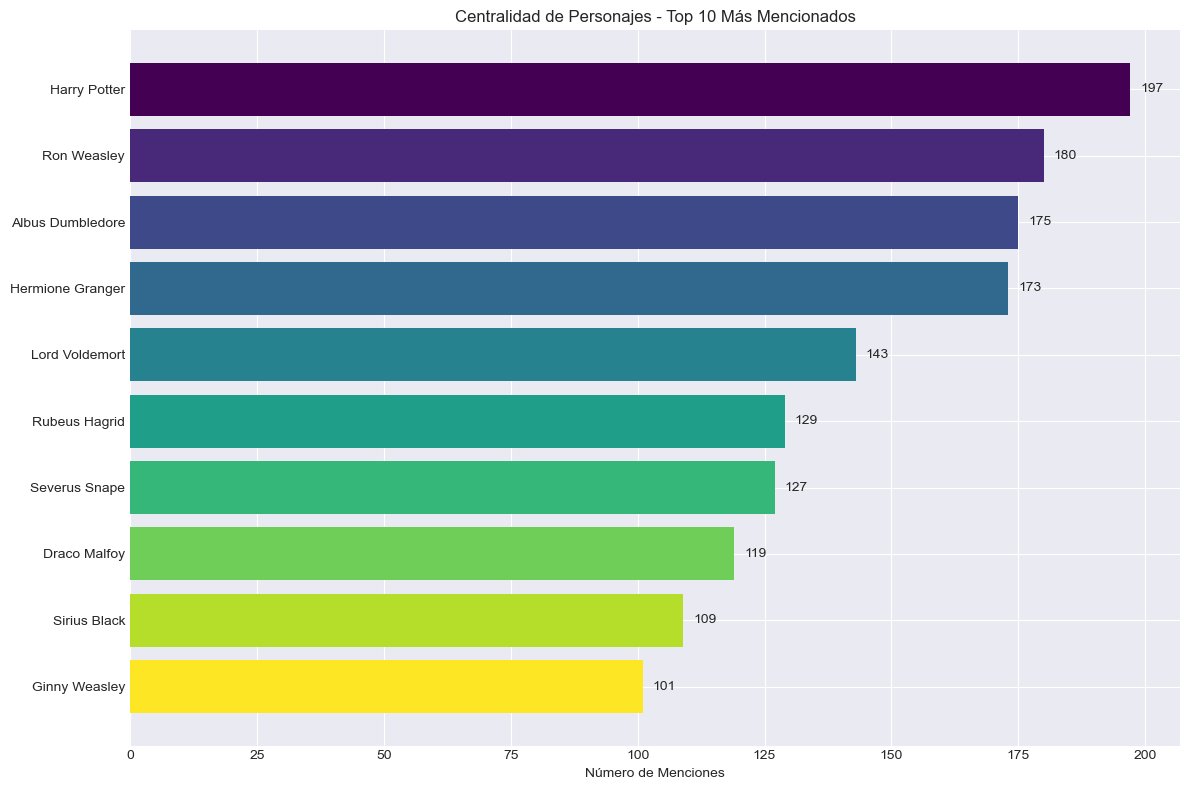


  2. EVOLUCIÓN NARRATIVA DE PERSONAJES
📈 EVOLUCIÓN DE PERSONAJES PRINCIPALES A LO LARGO DE LA SAGA:
   Harry Potter        : [17, 17, 22, 37, 38, 30, 36] (Total: 197)
   Hermione Granger    : [12, 15, 22, 30, 35, 25, 34] (Total: 173)
   Ron Weasley         : [12, 17, 22, 32, 38, 26, 33] (Total: 180)
   Albus Dumbledore    : [14, 15, 16, 29, 36, 30, 35] (Total: 175)
   Severus Snape       : [11, 9, 17, 21, 22, 22, 25] (Total: 127)
   Lord Voldemort      : [7, 9, 14, 23, 30, 26, 34] (Total: 143)
   Rubeus Hagrid       : [14, 13, 17, 22, 23, 16, 24] (Total: 129)
   Draco Malfoy        : [10, 14, 13, 20, 24, 26, 12] (Total: 119)


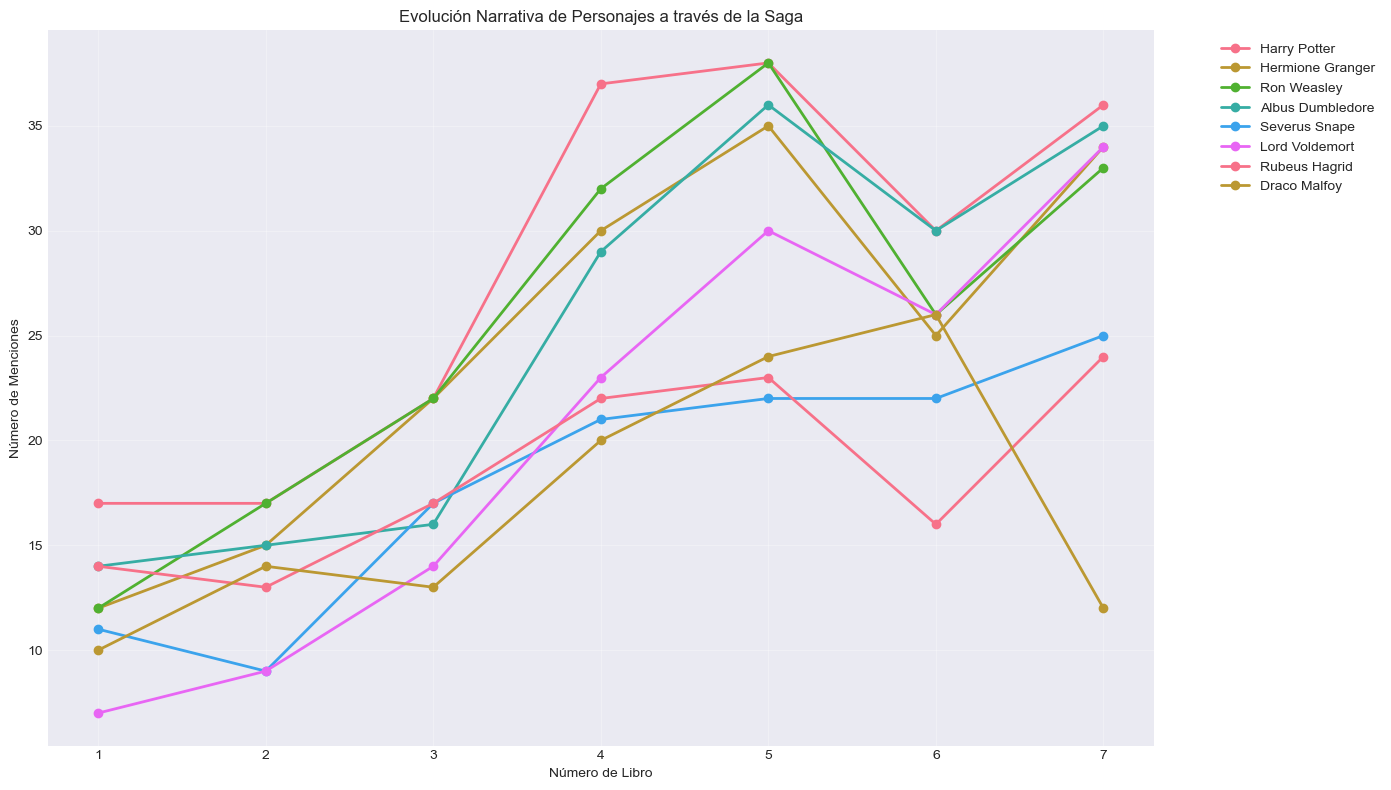


  3. RELEVANCIA DE ARTEFACTOS MÁGICOS
🪄 ARTEFACTOS MÁS RELEVANTES EN LA SAGA:
    1. Wand                      179 menciones (24.5%)
    2. Invisibility Cloak         73 menciones (10.0%)
    3. Snitch                     37 menciones (5.1%)
    4. Deathly Hallows            34 menciones (4.7%)
    5. Patronus                   30 menciones (4.1%)
    6. Dementor                   29 menciones (4.0%)
    7. Horcrux                    28 menciones (3.8%)
    8. Pensieve                   26 menciones (3.6%)
    9. Fluffy                     25 menciones (3.4%)
   10. Firebolt                   25 menciones (3.4%)

📚 TOP 5 ARTEFACTOS MÁS RELEVANTES POR LIBRO:

📖 LIBRO 1:
   1. Wand                       12 menciones
   2. Fluffy                      6 menciones
   3. Invisibility Cloak          6 menciones
   4. Snitch                      4 menciones
   5. Mirror Of Erised            3 menciones

📖 LIBRO 2:
   1. Wand                       16 menciones
   2. Sorting Hat                

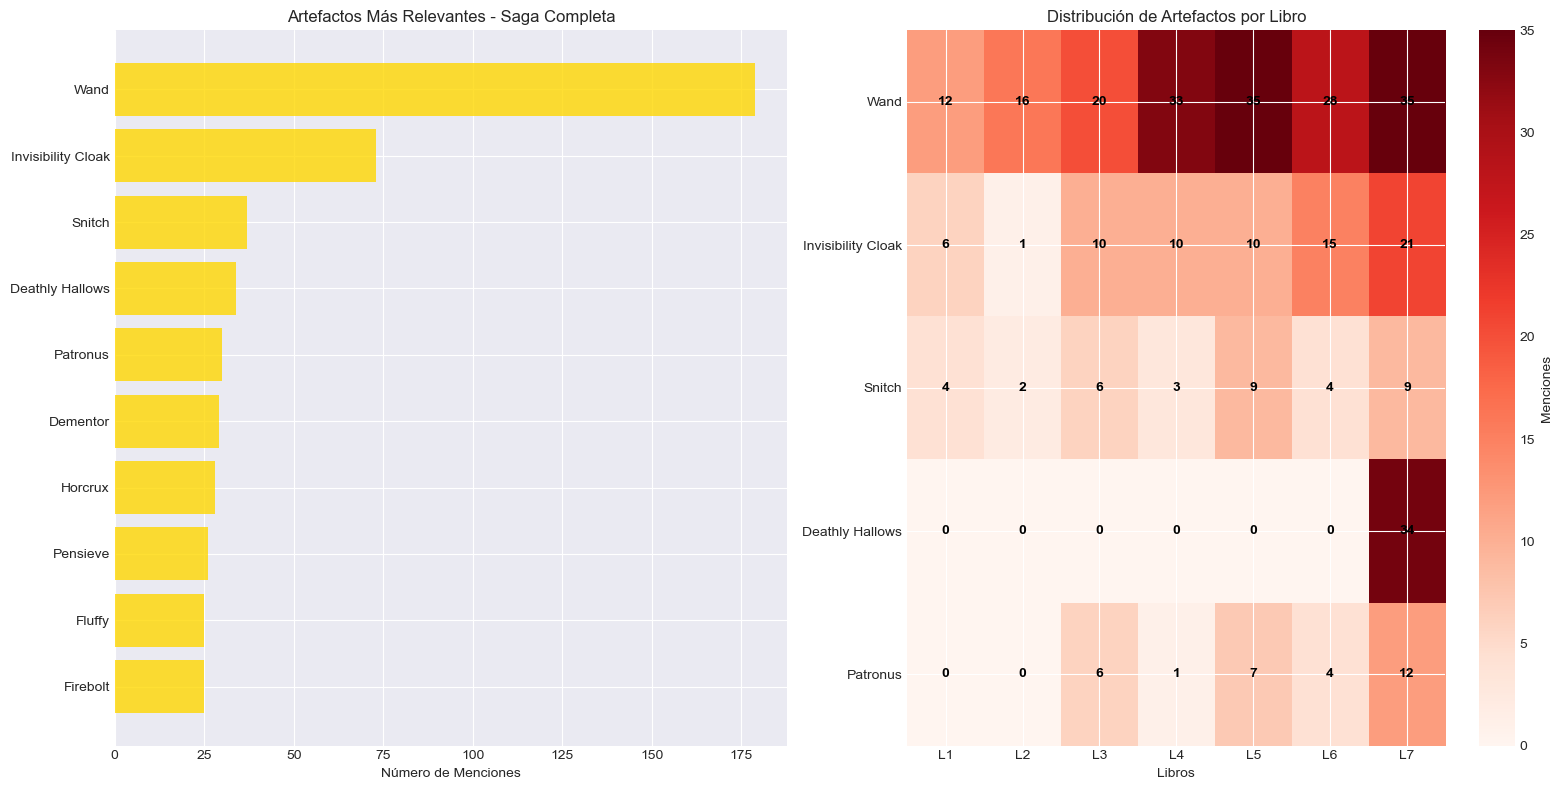


  RESUMEN EJECUTIVO DEL ANÁLISIS ENFOCADO
✅ Análisis enfocado completado exitosamente
📊 Resultados disponibles:
   • Centralidad de Personajes: Frecuencia y relevancia de personajes principales
   • Evolución Narrativa: Trayectoria de personajes a través de la saga
   • Relevancia de Artefactos: Objetos mágicos más importantes por libro y globalmente

🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯
✅ ANÁLISI COMPLETDO
🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯

📊 RESUMEN DE DETECCIONES DEL MODELO HÍBRIDO:

👥 PERSONAJES:
   • Personajes únicos detectados: 42
   • Total de menciones: 2,477

🪄 OBJETOS MÁGICOS:
   • Objetos únicos detectados: 38
   • Total de menciones: 730

👑 TOP 5 PERSONAJES MÁS MENCIONADOS:
   1. Harry Potter               197 menciones
   2. Ron Weasley                180 menciones
   3. Albus Dumbledore           175 menciones
   4. Hermione Granger           173 menciones
   5. Lord Voldemort             143 menciones

🏺 TOP 5 OBJETOS MÁGICOS MÁS MENCIONADOS:
   1. Wand                       179 mencione

In [ ]:

eda_hibrido = HarryPotterEDA(df_libros)

# Ejecutar análisis completo
resultados_hibrido = eda_hibrido.generar_analisis_completo()

print("\n" + "🎯" * 25)
print("✅ ANÁLISI COMPLETDO")
print("🎯" * 25)

# === RESUMEN DE RESULTADOS ===
print("\n📊 RESUMEN DE DETECCIONES DEL MODELO:")

# Estadísticas generales
total_personajes = len(eda_hibrido.conteos_globales['PERSONAJE'])
total_objetos = len(eda_hibrido.conteos_globales['OBJETO_MAGICO'])
menciones_personajes = sum(eda_hibrido.conteos_globales['PERSONAJE'].values())
menciones_objetos = sum(eda_hibrido.conteos_globales['OBJETO_MAGICO'].values())

print(f"\n👥 PERSONAJES:")
print(f"   • Personajes únicos detectados: {total_personajes}")
print(f"   • Total de menciones: {menciones_personajes:,}")

print(f"\n🪄 OBJETOS MÁGICOS:")
print(f"   • Objetos únicos detectados: {total_objetos}")
print(f"   • Total de menciones: {menciones_objetos:,}")

# Top 5 de cada categoría
print(f"\n👑 TOP 5 PERSONAJES MÁS MENCIONADOS:")
top5_personajes = eda_hibrido.conteos_globales['PERSONAJE'].most_common(5)
for i, (personaje, menciones) in enumerate(top5_personajes, 1):
    print(f"   {i}. {personaje:<25} {menciones:>4} menciones")

print(f"\n🏺 TOP 5 OBJETOS MÁGICOS MÁS MENCIONADOS:")
top5_objetos = eda_hibrido.conteos_globales['OBJETO_MAGICO'].most_common(5)
for i, (objeto, menciones) in enumerate(top5_objetos, 1):
    print(f"   {i}. {objeto:<25} {menciones:>4} menciones")
